In [14]:
%matplotlib inline
import matplotlib.pyplot as plt
import os
import json
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import scipy
import random
import librosa
import librosa.display
import IPython.display
from collections import namedtuple

from src.data import create_audio_transform, load_audio
from src.models import Autoencoder, Classifier, Segmenter1d
from src import utils

# Segmentation

In [2]:
model_dir = 'train_results/segmentation/20200730-010324'

hparams = json.load(open(os.path.join(model_dir, 'hparams.json'), 'rb'))

weights_path = sorted([x for x in os.listdir(model_dir) if 'model' in x], key=lambda x : int(x.split('-')[-1].split('.')[0]))[-1]
weights_path = os.path.join(model_dir, weights_path)
print(weights_path)

train_results/segmentation/20200730-010324/model-2160.weights


In [3]:
model = Segmenter1d(h_dim=hparams['hidden_dim'])
model.load_state_dict(torch.load(weights_path))
model.eval()

Segmenter1d(
  (encode): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): MaxPool2d(kernel_size=(2, 1), stride=(2, 1), padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): ReLU()
    (6): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): MaxPool2d(kernel_size=(2, 1), stride=(2, 1), padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU()
    (10): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): MaxPool2d(kernel_size=(2, 1), stride=(2, 1), padding=0, dilation=1, ceil_mode=False)
    (12): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU()
    (14): BatchNorm2d(128, eps=1e-05, momen

In [4]:
transform = create_audio_transform(
    hparams['sample_rate'],
    n_samples=None,
    random_crop=False,
    feature_type=hparams['feature_type'],
    resize=hparams['resize'],
    normalize=hparams['normalize'],
    standardize=hparams['standardize'],
    standardize_mean=hparams['standardize_mean'],
    standardize_std=hparams['standardize_std'],
    spec_augment=False
)

In [85]:
#sample_file = 'samples/180156__klankbeeld__traffic-horns-city-nervous-busy.wav'
#sample_file = 'samples/269570__vonora__cuckoo-the-nightingale-duet.wav'
sample_file = 'samples/504900__soundmast123__restaurant-ambience.wav'
#sample_file = 'samples/389684__meggiepie__pots-and-pans.wav'

audio = load_audio(sample_file, sample_rate=hparams['sample_rate'], t_start=0)

In [86]:
IPython.display.Audio(audio, rate=hparams['sample_rate'])

In [87]:
with torch.no_grad():
    features = transform(audio).unsqueeze(0)
    outputs = model(features)
    outputs = (outputs > 0.5).to(float)

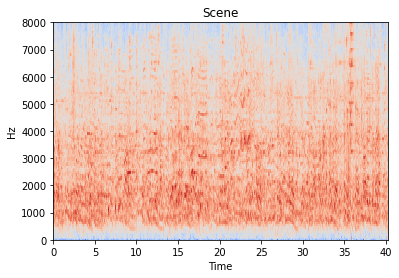

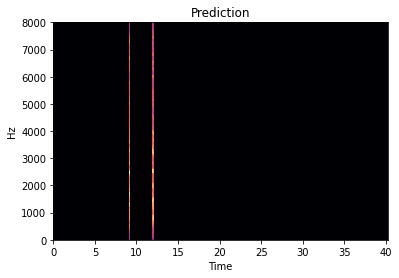

In [88]:
scene = features[0].cpu().numpy().squeeze()
pred_mask = outputs.detach().cpu().numpy()
pred_segment = np.ones_like(scene)*scene.min() * (1 - pred_mask) + pred_mask*scene

librosa.display.specshow(scene, sr=16000, x_axis='time', y_axis='hz')
plt.title('Scene')
plt.show()
librosa.display.specshow(pred_segment, sr=16000, x_axis='time', y_axis='hz')
plt.title('Prediction')
plt.show()

In [89]:
audio_mask = F.interpolate(outputs[None, ...], size=audio.shape[-1]).squeeze().numpy()
samples = (audio_mask*audio.numpy()).mean(0)

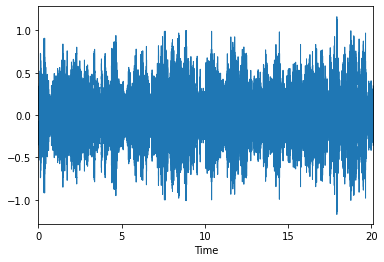

In [90]:
librosa.display.waveplot(audio.numpy().mean(0), sr=hparams['sample_rate'])

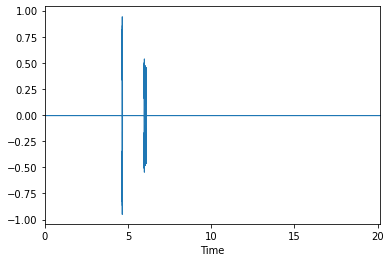

In [91]:
librosa.display.waveplot(samples, sr=hparams['sample_rate'])

In [92]:
IPython.display.Audio(samples, rate=hparams['sample_rate'])

# Classifier

In [7]:
model_dir = 'train_results/classifier/20200725-005643'

hparams = json.load(open(os.path.join(model_dir, 'hparams.json'), 'rb'))
label_dict = json.load(open(os.path.join(model_dir, 'label_dict.json'), 'rb'))

weights_path = sorted([x for x in os.listdir(model_dir) if 'model' in x], key=lambda x : int(x.split('-')[-1].split('.')[0]))[-1]
weights_path = os.path.join(model_dir, weights_path)
print(weights_path)

train_results/classifier/20200725-005643/model-4539.weights


In [12]:
model = Classifier(len(label_dict), h_dim=hparams['hidden_dim'])
model.load_state_dict(torch.load(weights_path))
model.eval()

Classifier(
  (encode): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): ReLU()
    (6): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU()
    (10): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (12): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU()
    (14): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_run

In [13]:
transform = create_audio_transform(
    hparams['sample_rate'],
    n_samples=hparams['n_samples'],
    random_crop=False,
    feature_type=hparams['feature_type'],
    resize=hparams['resize'],
    normalize=hparams['normalize'],
    standardize=hparams['standardize'],
    standardize_mean=hparams['standardize_mean'],
    standardize_std=hparams['standardize_std'],
    spec_augment=False
)

In [78]:
sample_file = 'samples/180156__klankbeeld__traffic-horns-city-nervous-busy.wav'
#sample_file = 'samples/269570__vonora__cuckoo-the-nightingale-duet.wav'
#sample_file = 'samples/504900__soundmast123__restaurant-ambience.wav'
#sample_file = 'samples/389684__meggiepie__pots-and-pans.wav'

audio = load_audio(sample_file, sample_rate=hparams['sample_rate'], t_start=0)

In [79]:
IPython.display.Audio(audio, rate=hparams['sample_rate'])

In [80]:
frames = utils.partition_audio(audio, [0.5, 1, 2, 3, 4], 2, sample_rate=hparams['sample_rate'])

In [81]:
samples = []

with torch.no_grad():
    for frame in frames:
        features = transform(frame).unsqueeze(0)
        outputs = model(features)
        
        pred = outputs.argmax(-1).item()
        pred = label_dict[str(pred)]
        samples.append((frame, pred))
        
instruments = [x[0] for x in samples if x[1] == 'instrument']
non_instruments = [x[0] for x in samples if x[1] == 'non_instrument']

In [82]:
len(instruments), len(non_instruments)

(9, 91)

In [83]:
random.shuffle(instruments)
random.shuffle(non_instruments)

#### Instruments

In [84]:
IPython.display.Audio(instruments[0], rate=hparams['sample_rate'])

In [85]:
IPython.display.Audio(instruments[1], rate=hparams['sample_rate'])

In [86]:
IPython.display.Audio(instruments[2], rate=hparams['sample_rate'])

#### Non-instruments

In [87]:
IPython.display.Audio(non_instruments[0], rate=hparams['sample_rate'])

In [88]:
IPython.display.Audio(non_instruments[1], rate=hparams['sample_rate'])

In [89]:
IPython.display.Audio(non_instruments[2], rate=hparams['sample_rate'])

# Autoencoder

In [2]:
model_dir = 'train_results/autoencoder/20200723-231955'

hparams = json.load(open(os.path.join(model_dir, 'hparams.json'), 'rb'))

weights_path = sorted([x for x in os.listdir(model_dir) if 'model' in x], key=lambda x : int(x.split('-')[-1].split('.')[0]))[-1]
weights_path = os.path.join(model_dir, weights_path)
print(weights_path)

train_results/autoencoder/20200722-202319/model-79794.weights


In [4]:
model = Autoencoder(h_dim=hparams['hidden_dim'], sigmoid=(not hparams['standardize']))
model.load_state_dict(torch.load(weights_path))
model.eval()

Autoencoder(
  (encode): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 4), stride=(1, 1), padding=(1, 4))
    (1): ReLU()
    (2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): ReLU()
    (6): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU()
    (10): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (12): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU()
    (14): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_ru

In [5]:
transform = create_audio_transform(
    hparams['sample_rate'],
    n_samples=hparams['n_samples'],
    random_crop=False,
    feature_type=hparams['feature_type'],
    resize=hparams['resize'],
    normalize=hparams['normalize'],
    standardize=hparams['standardize'],
    standardize_mean=hparams['standardize_mean'],
    standardize_std=hparams['standardize_std'],
    spec_augment=False
)

In [7]:
if hparams['standardize']:
    loss_fn = nn.MSELoss(reduction='none')
else:
    loss_fn = nn.BCELoss(reduction='none')

##### Real instrument

In [11]:
fname = 'data/nsynth/nsynth-test/audio/organ_electronic_057-047-100.wav'

audio = load_audio(fname, sample_rate=hparams['sample_rate'], t_start=0)
features = transform(audio)

In [12]:
with torch.no_grad():
    features = features.unsqueeze(0)
    outputs = model(features)

    print(loss_fn(outputs, features).mean().item())

0.02046317234635353


##### Noise

In [13]:
features = torch.tensor(np.random.rand(1, 1, 128, 251), dtype=torch.float32)

In [14]:
with torch.no_grad():
    outputs = model(features)

    print(loss_fn(outputs, features).mean().item())

0.09657275676727295


##### Sample

In [124]:
#sample_file = 'samples/180156__klankbeeld__traffic-horns-city-nervous-busy.wav'
#sample_file = 'samples/269570__vonora__cuckoo-the-nightingale-duet.wav'
#sample_file = 'samples/504900__soundmast123__restaurant-ambience.wav'
sample_file = 'samples/389684__meggiepie__pots-and-pans.wav'

In [125]:
audio = load_audio(sample_file, sample_rate=hparams['sample_rate'], t_start=0)

In [126]:
IPython.display.Audio(audio, rate=hparams['sample_rate'])

In [128]:
frames = partition_audio(audio, [0.5, 1, 2, 3, 4], 2, sample_rate=hparams['sample_rate'])

In [145]:
Sample = namedtuple('Sample', 'score sample features reconstruction embedding')

In [155]:
samples = []

with torch.no_grad():
    for frame in frames:
        features = transform(frame).unsqueeze(0)
        outputs = model(features)
        embd = model.encode(features).squeeze()
        loss = loss_fn(outputs, features)
        
        frame_length = int(loss.shape[-1] * (frame.shape[-1] / hparams['n_samples']))
        loss = loss.narrow(-1, 0, frame_length).mean()
        
        
        samples.append(Sample(
            score=loss.item(),
            sample=frame.numpy(),
            features=features.squeeze().numpy(),
            reconstruction=outputs.squeeze().numpy(),
            embedding=embd.numpy()
        ))
samples = sorted(samples, key=lambda x : x.score)

##### Best

In [1]:
IPython.display.Audio(samples[1].sample, rate=hparams['sample_rate'])

NameError: name 'IPython' is not defined

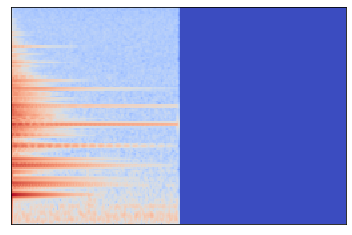

In [176]:
librosa.display.specshow(samples[1].features)

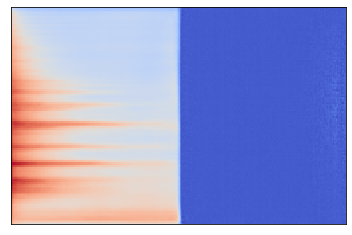

In [177]:
librosa.display.specshow(samples[1].reconstruction)

##### Worst

In [158]:
IPython.display.Audio(samples[-1].sample, rate=hparams['sample_rate'])

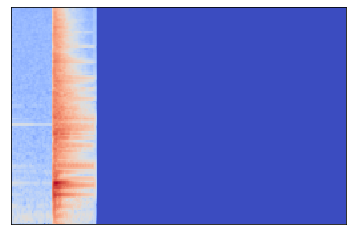

In [160]:
librosa.display.specshow(samples[-1].features)

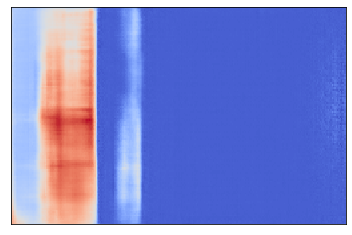

In [161]:
librosa.display.specshow(samples[-1].reconstruction)

### Clustering

In [103]:
from sklearn.cluster import KMeans
from collections import Counter

In [104]:
kmeans = KMeans(n_clusters=5)

In [105]:
clusters = kmeans.fit_predict([x[2].numpy() for x in scored_frames])

In [114]:
clustered_frames = dict()

for c, frame in zip(clusters, scored_frames):
    clustered_frames[c] = clustered_frames.get(c, []) + [frame[1]]

In [120]:
IPython.display.Audio(clustered_frames[1][0], rate=hparams['sample_rate'])

In [121]:
IPython.display.Audio(clustered_frames[1][1], rate=hparams['sample_rate'])

In [122]:
IPython.display.Audio(clustered_frames[1][2], rate=hparams['sample_rate'])

In [123]:
IPython.display.Audio(clustered_frames[1][3], rate=hparams['sample_rate'])